In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from mplsoccer.pitch import Pitch, add_image
from scipy.ndimage import gaussian_filter
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.patheffects as path_effects

pd.set_option('max_columns', None)
pd.set_option('max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

In [5]:
opta = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Opta/opta.csv')

opta.groupby(['eventType','eventSubType'])\
        .agg({'matchId':'count'})\
        .reset_index()\
        .rename(columns={'matchId':'countActions'})\
        .sort_values(['eventType','countActions'], ascending=[True,False])

,eventType,eventSubType,countActions
15,attack,Pass,1062965
9,attack,Failed Pass,301167
3,attack,Bad Touch,39629
13,attack,Lost Possession,28217
11,attack,Fouled,28070
12,attack,Lost Aerial Duel,27784
6,attack,Dribble,26658
8,attack,Failed Dribble,22500
4,attack,Chance Created,22056
1,attack,Aerial Duel,21983


In [7]:
opta_shots = opta.loc[opta['eventType'] == 'shot'].copy()
opta_goals = opta.loc[opta['eventSubType'] == 'Goal'].copy()

In [66]:
df_shots = opta_shots.copy()
df_shots['goal'] = df_shots.eventSubType.apply(lambda x: True if x == 'Goal' else False)
df_shots = df_shots[['competition','season','x1','y1','goal']].rename(columns={'x1':'x','y1':'y'})
df_shots.reset_index(drop=True, inplace=True)
df_shots['goal_number'] = df_shots.goal.cumsum() - 1

X = df_shots[['x', 'y']]
y = df_shots.goal

df_goals = df_shots[df_shots.goal].copy()

In [67]:
df_shots

,competition,season,x,y,goal,goal_number
0,English Premier League,2017/18,88.5,52.6,True,0
1,English Premier League,2017/18,85.3,46.7,False,0
2,English Premier League,2017/18,97.6,46.6,True,1
3,English Premier League,2017/18,80.7,72.0,False,1
4,English Premier League,2017/18,78.6,64.3,False,1
...,...,...,...,...,...,...
34614,Champions League,2018/19,86.6,54.0,False,3750
34615,Champions League,2018/19,88.2,67.6,True,3751
34616,Champions League,2018/19,78.1,71.5,False,3751
34617,Champions League,2018/19,86.5,71.8,False,3751


## Quick first look using Scott's Heuristic for bw

In [10]:
pitch = Pitch(figsize=(16, 20), tight_layout=False, view='half', orientation='vertical', line_zorder=2,
              pitch_type='opta', pad_left=-13.25, pad_right=-13.25, pad_bottom=-12, pad_top=1)

/Users/christian/anaconda2/envs/py37_football/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/christian/anaconda2/envs/py37_football/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using scott for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/christian/anaconda2/envs/py37_football/lib/python3.7/site-packages/seaborn/distributions.py:1668: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


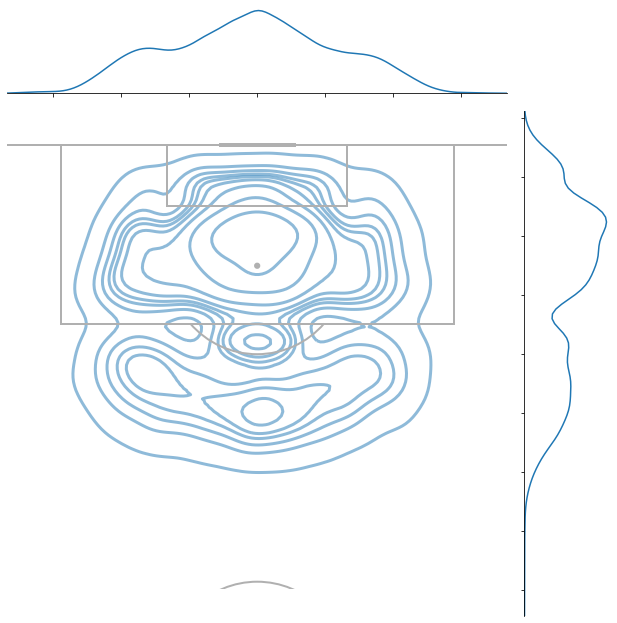

In [15]:
joint_kws = {'shade': False, 'linewidths': 3, 'kind': 'kde', 'bw': 'scott', 'kernel':'gau'}
g = pitch.jointplot(df_shots.x, df_shots.y, height=9, alpha=0.5, **joint_kws)

# Fitting a cross-validated Kernel Density estimator

In [68]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
skf.get_n_splits(df_shots[['x', 'y']], df_shots.goal)

10

In [69]:
goals_cv = []
shots_cv = []

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    
    split_train_shots = X.iloc[train_index]
    split_test_shots = X.iloc[test_index]
    
    split_train_y = y.iloc[train_index]
    split_test_y = y.iloc[test_index]
    
    split_train_goals = split_train_shots[split_train_y]
    split_test_goals = split_test_shots[split_test_y]
    
    goals_train_idx = split_train_goals.index.tolist()
    goals_test_idx = split_test_goals.index.tolist()
    goals_train_idx = df_shots.iloc[goals_train_idx].goal_number.tolist()
    goals_test_idx = df_shots.iloc[goals_test_idx].goal_number.tolist()
    
    goals_cv.append((goals_train_idx, goals_test_idx))
    shots_cv.append((train_index, test_index))
    
df_goals.reset_index(drop=True, inplace=True)

In [142]:
param_grid = {'bandwidth': np.linspace(1., 2., 100)}
grid_goals = GridSearchCV(KernelDensity(kernel='gaussian'), param_grid=param_grid , cv=goals_cv, n_jobs=-1)
grid_goals.fit(df_goals[['x', 'y']])
print(grid_goals.best_estimator_)

KernelDensity(bandwidth=1.4141414141414141)


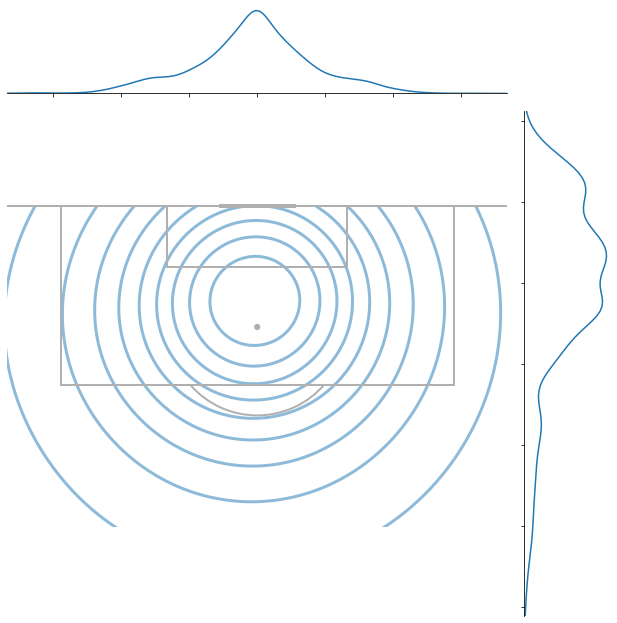

In [144]:
joint_kws = {'shade': False, 'linewidths': 3, 'kind': 'kde', 
             'bw': 1.4141414141414141, 'kernel':'gau'}
g = pitch.jointplot(df_goals.x, df_goals.y, height=9, alpha=0.5, **joint_kws)


In [72]:
grid_shots = GridSearchCV(KernelDensity(kernel='gaussian'), param_grid=param_grid , cv=shots_cv, n_jobs=-1)
grid_shots.fit(df_shots[['x', 'y']])
print(grid_shots.best_estimator_)

KernelDensity(bandwidth=1.0909090909090908)


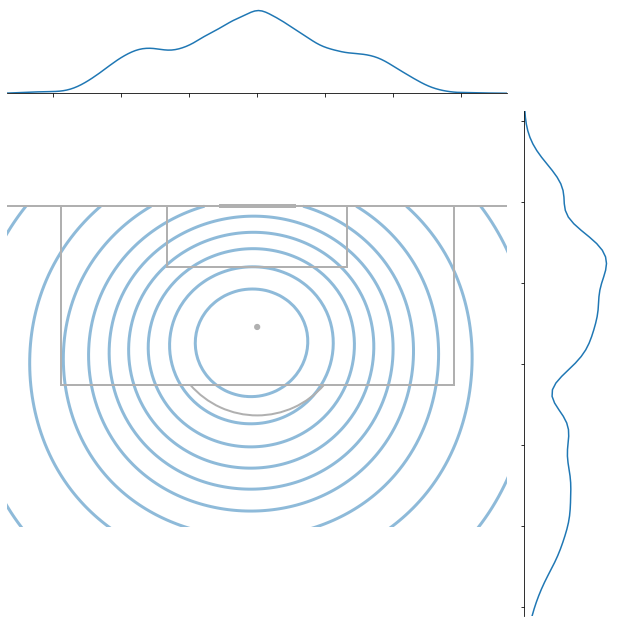

In [145]:
joint_kws = {'shade': False, 'linewidths': 3, 'kind': 'kde',
             'bw': 1.0909090909090908, 'kernel':'gau'}
g = pitch.jointplot(df_shots.x, df_shots.y, height=9, alpha=0.5, **joint_kws)


# Plot both on same pitch

In [76]:
kernel_middle = (1.4141414141414141 + 1.0909090909090908)/2

In [77]:
model_goals = KernelDensity(kernel='gaussian', bandwidth=kernel_middle)
model_shots = KernelDensity(kernel='gaussian', bandwidth=kernel_middle)

In [78]:
model_goals.fit(df_goals[['x', 'y']])
model_shots.fit(df_shots[['x', 'y']])

KernelDensity(bandwidth=1.2525252525252526)

In [120]:
x_grid = np.arange(0, 105.1, 0.5)
y_grid = np.arange(0, 68.1, 0.5)
X, Y = np.meshgrid(x_grid, y_grid)
sample = np.vstack([X.ravel(), Y.ravel()]).T

In [121]:
shot_scores = np.exp(model_shots.score_samples(sample))
goal_scores = np.exp(model_goals.score_samples(sample))

In [122]:
shot_scores = shot_scores.reshape(X.shape)
goal_scores = goal_scores.reshape(X.shape)

In [123]:
n_shots = len(df_shots)
n_goals = len(df_goals)

In [124]:
goal_scores.shape

(137, 211)

In [125]:
shot_scores.shape

(137, 211)

In [126]:
n_goals

3752

In [127]:
n_shots

34619

In [136]:
def safe_divide(a, b):
    return np.divide(a, b, out=np.zeros_like(a), where=b != 0)

prob_scoring = (safe_divide(goal_scores, shot_scores)) * (n_goals / n_shots)

In [137]:
prob_scoring

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        6.92589939e-002, 1.05414166e-002, 1.58557017e-003],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        1.95007863e+005, 1.43990432e+005, 4.61152405e+004],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        2.35925894e+002, 4.47551585e-005, 1.19603257e+001],
       ...,
       [1.33918287e-215, 1.30795059e-212, 1.27744671e-209, ...,
        7.30657335e-004, 4.38879885e-004, 2.62556695e-004],
       [1.30741850e-216, 1.27692702e-213, 1.24714667e-210, ...,
        5.40183840e-004, 3.18256828e-004, 1.86905170e-004],
       [1.27640755e-217, 1.24663931e-214, 1.21756533e-211, ...,
        4.59228780e-004, 2.65567025e-004, 1.52925053e-004]])

Text(35, 80, 'Goal density (contour lines)')

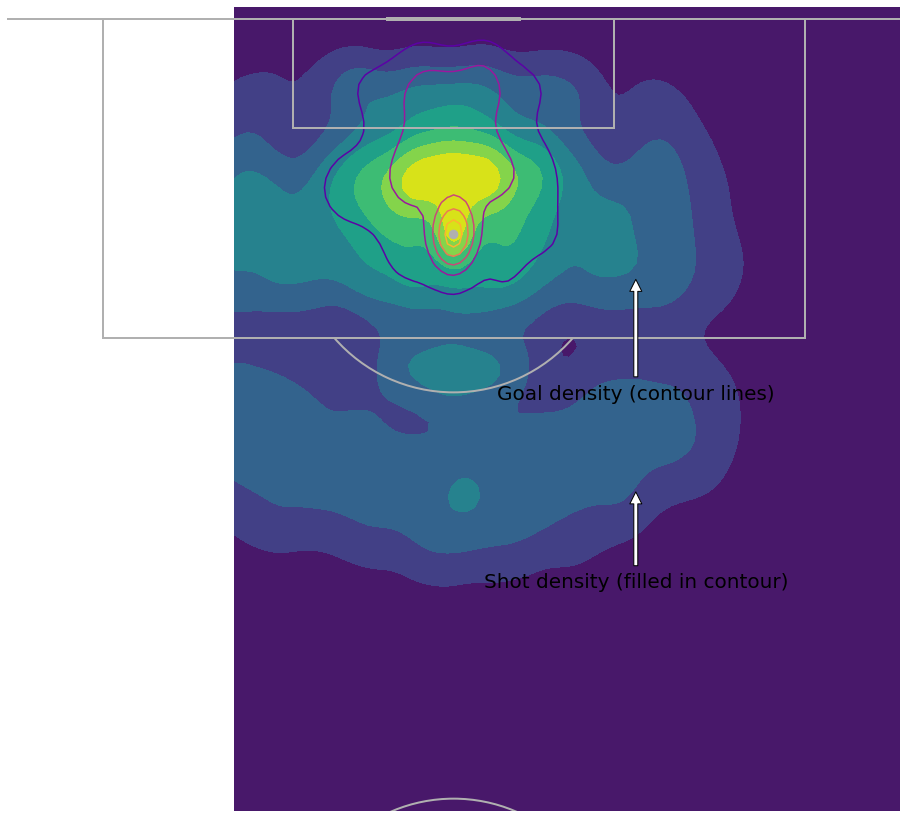

In [138]:
pitch = Pitch(figsize=(16, 20), tight_layout=False, view='half', orientation='vertical', line_zorder=2,
              pitch_type='opta', pad_left=-13.25, pad_right=-13.25, pad_bottom=-12, pad_top=1)

fig, ax = pitch.draw()

contour1 = ax.contourf(Y, X, shot_scores, cmap='viridis', zorder=2, alpha=1)
contour2 = ax.contour(Y, X, goal_scores, cmap='plasma', zorder=2, alpha=1)

pitch.annotate('Shot density (filled in contour)', (75, 35), (70, 35), arrowprops=dict(facecolor='white', shrink=0.05),
               fontsize=20, va='center', ha='center', ax=ax)
pitch.annotate('Goal density (contour lines)', (86.4, 35), (80, 35), arrowprops=dict(facecolor='white', shrink=0.05),
               fontsize=20, va='center', ha='center', ax=ax)


In [139]:
prob_scoring = prob_scoring * 100

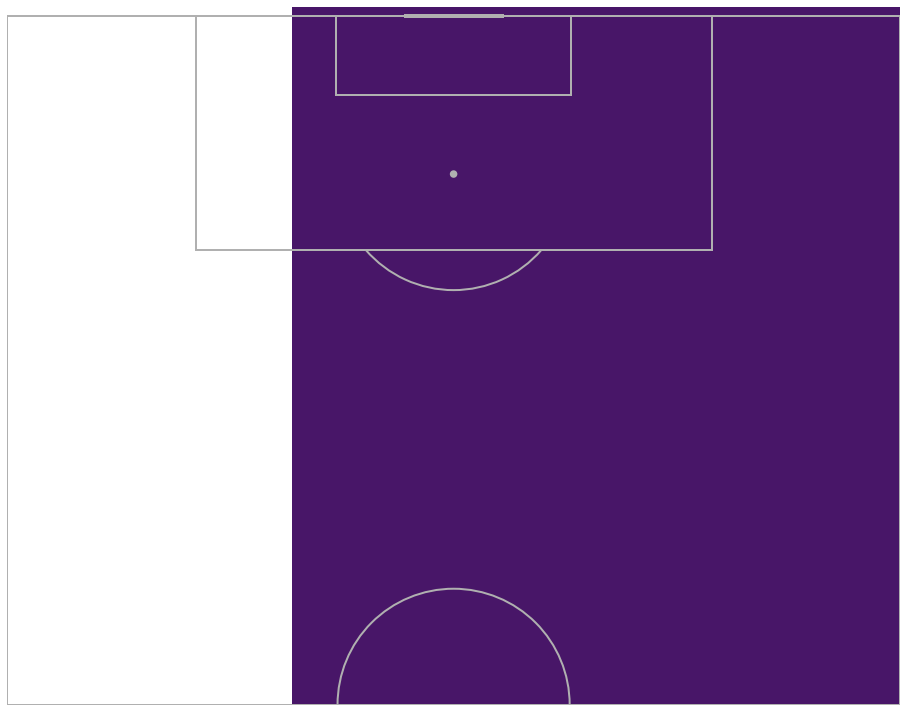

In [148]:
pitch = Pitch(figsize=(16, 20), tight_layout=False, view='half', orientation='vertical', line_zorder=2,
              pitch_type='opta', pad_left=0, pad_right=0, pad_bottom=0, pad_top=1)

fig, ax = pitch.draw()

contour1 = ax.contourf(Y, X, prob_scoring, cmap='viridis', levels=9, zorder=2, alpha=1)

label = ax.clabel(contour1, colors='white', fontsize=14, fmt='%d%%', use_clabeltext=True, inline=True)

for l in label:
    l.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])

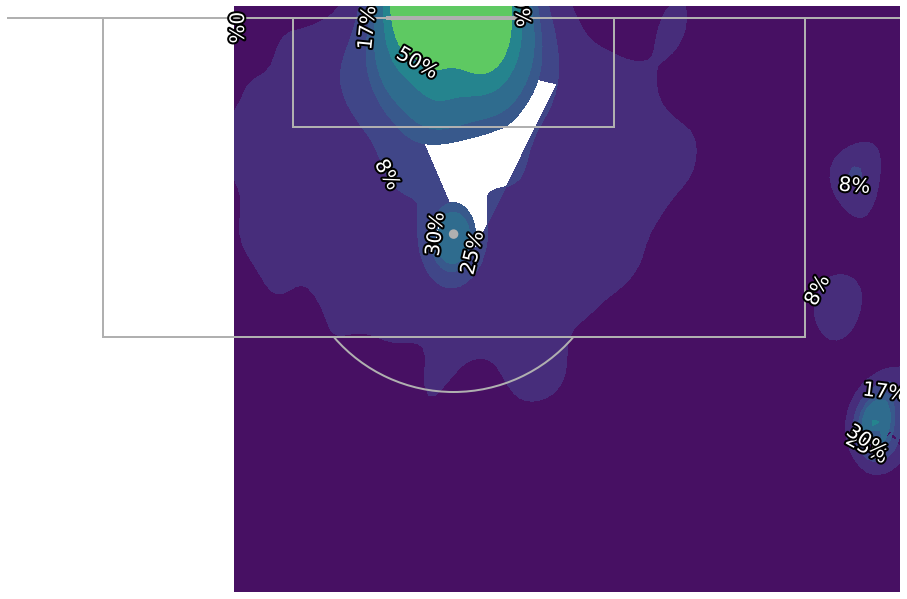

In [141]:
pitch = Pitch(figsize=(16, 20), tight_layout=False, view='half', orientation='vertical', line_zorder=2,
              pitch_type='opta', pad_left=-13.25, pad_right=-13.25, pad_bottom=-30, pad_top=1)

fig, ax = pitch.draw()

levels = np.array([0, 8, 17, 25, 30, 40, 50, 100])

prob_scoring_smooth = gaussian_filter(prob_scoring, 1)

contour1 = ax.contourf(Y, X, prob_scoring_smooth, cmap='viridis', levels=levels, zorder=2, alpha=1)
label = ax.clabel(contour1, colors='white', fontsize=20, fmt='%d%%', inline=True, use_clabeltext=True)

for l in label:
    l.set_path_effects([path_effects.Stroke(linewidth=4, foreground='black'), path_effects.Normal()])